In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import Ridge
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.decomposition import PCA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pmdarima as pm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import ta

# 1. Assessing the Influence of Economic Cycles on the VN-Index: A Comprehensive Analysis
# 1.1 Exploratory Data Analyst


# Vnindex

In [70]:
# Read VNINDEX data
# VNINDEX data
df_VNINDEX_raw= pd.read_csv(r"D:\Down\VNINDEX-2003-2023.csv")
# Rename columns
df_VNINDEX_raw=df_VNINDEX_raw.rename(columns={'Ngày':'Date','Lần cuối':'Close','Mở':'Open','Cao':'High','Thấp':'Low','KL':'Volumne','% Thay đổi':'Change %'})
df_VNINDEX_raw['Date'] = pd.to_datetime(df_VNINDEX_raw['Date'], format='%d/%m/%Y')
# Converting numerical columns from strings to numbers, handling commas
df_VNINDEX_raw['Close'] = pd.to_numeric(df_VNINDEX_raw['Close'].str.replace(',', '', regex=True), errors='coerce')
df_VNINDEX_raw['Open'] = pd.to_numeric(df_VNINDEX_raw['Open'].str.replace(',', '', regex=True), errors='coerce')
df_VNINDEX_raw['High'] = pd.to_numeric(df_VNINDEX_raw['High'].str.replace(',', '', regex=True), errors='coerce')
df_VNINDEX_raw['Low'] = pd.to_numeric(df_VNINDEX_raw['Low'].str.replace(',', '', regex=True), errors='coerce')
# Converting 'Change %' column by removing '%' symbol
df_VNINDEX_raw['Change %'] = pd.to_numeric(
    df_VNINDEX_raw['Change %'].str.replace('%', '', regex=False).str.replace(',', '', regex=True),
    errors='coerce')
# Define a function to convert 'Volumne' values
def convert_to_number(value):
    if isinstance(value, str):
        value = value.replace(',', '')  # Remove commas
        if 'M' in value:
            return float(value.replace('M', '')) * 1_000_000
        elif 'K' in value:
            return float(value.replace('K', '')) * 1_000
        elif 'B' in value:
            return float(value.replace('B', '')) * 1_000_000_000
    return pd.to_numeric(value, errors='coerce')  # Convert remaining values to numeric
# Apply the conversion function to 'Volumne' column
df_VNINDEX_raw['Volumne'] = df_VNINDEX_raw['Volumne'].apply(convert_to_number)

In [71]:
# Check basic infomation of data
print(df_VNINDEX_raw.info())

# Check null value
print(df_VNINDEX_raw.isnull().sum())

# Kiểm tra thống kê mô tả
print(df_VNINDEX_raw.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4988 entries, 0 to 4987
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      4988 non-null   datetime64[ns]
 1   Close     4988 non-null   float64       
 2   Open      4988 non-null   float64       
 3   High      4988 non-null   float64       
 4   Low       4988 non-null   float64       
 5   Volumne   4988 non-null   float64       
 6   Change %  4988 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 272.9 KB
None
Date        0
Close       0
Open        0
High        0
Low         0
Volumne     0
Change %    0
dtype: int64
                                Date        Close         Open         High  \
count                           4988  4988.000000  4988.000000  4988.000000   
mean   2014-01-06 09:34:29.927826944   693.705012   693.847117   698.170162   
min              2004-01-05 00:00:00   169.160000   167.690000   1

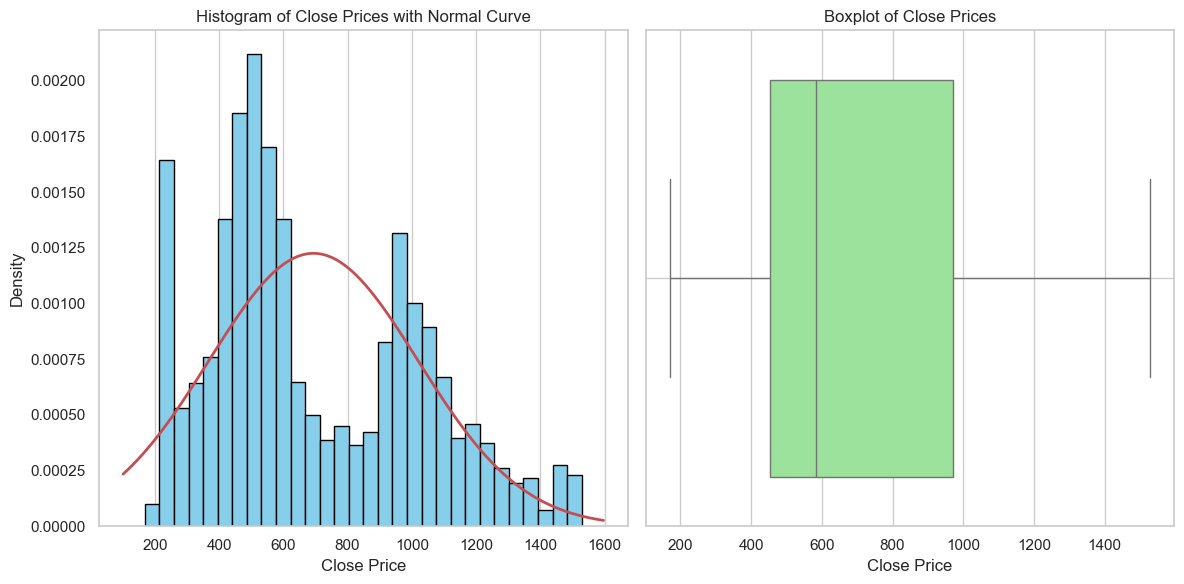

In [72]:
# Draw histogram and boxplot
# Create a figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Data
data = df_VNINDEX_raw['Close']

# Histogram
axs[0].hist(data, bins=30, color='skyblue', edgecolor='black', density=True)
axs[0].set_title('Histogram of Close Prices with Normal Curve')
axs[0].set_xlabel('Close Price')
axs[0].set_ylabel('Density')
axs[0].grid(axis='y')

# Add a Normal Distribution Curve
mu, std = norm.fit(data)  # Estimate mean and standard deviation
xmin, xmax = axs[0].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
axs[0].plot(x, p, 'r', linewidth=2)  # Plot normal distribution curve

# Boxplot
sns.boxplot(x=data, ax=axs[1], color='lightgreen')
axs[1].set_title('Boxplot of Close Prices')
axs[1].set_xlabel('Close Price')
axs[1].grid(True)

# Display the plots
plt.tight_layout()
plt.show()


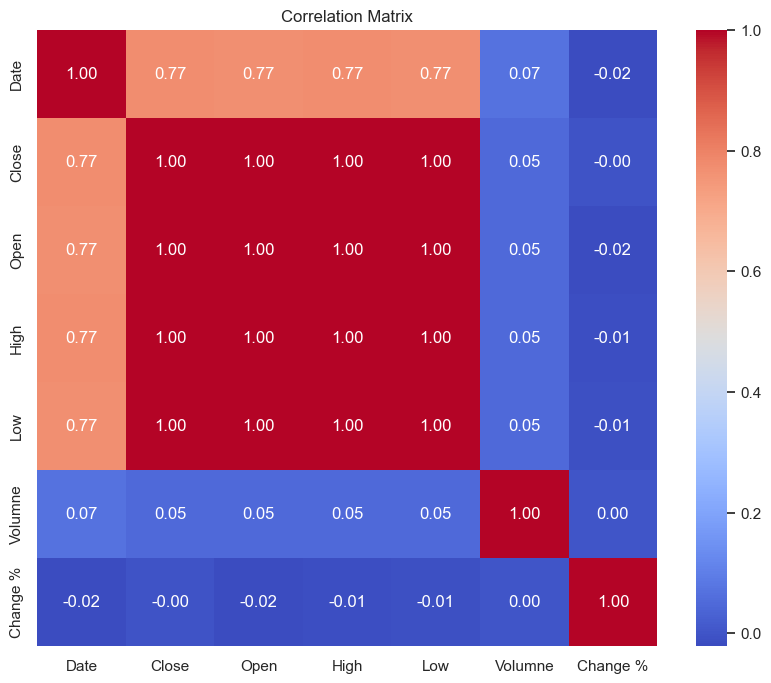

In [73]:
# Check correlation between variable
# Calculate the correlation matrix between the variables.
correlation_matrix = df_VNINDEX_raw.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [74]:
# Group data by Year
# Add a 'Year' column to store the year for each date
df_VNINDEX_raw['Year'] = df_VNINDEX_raw['Date'].dt.year

# Sort the DataFrame by 'Year' and 'Date' to get the last day of each year
df_VNINDEX_raw = df_VNINDEX_raw.sort_values(['Year', 'Date'])

# Get the last value of the 'Close' column for each year
df_VNINDEX = df_VNINDEX_raw.groupby('Year').last()['Close'].reset_index()

# Display the result
df_VNINDEX.set_index('Year', inplace=True)
df_VNINDEX.tail(5)


,Close
Year,
2019,960.99
2020,1103.87
2021,1498.28
2022,1007.09
2023,1129.93


# Macroeconomics

In [76]:
# Read the macroeconomics data
df_macroeconomics_raw = pd.read_excel(r"C:\Users\ADMIN\OneDrive - Trường ĐH CNTT - University of Information Technology\effort\ki1_nam3\Phân tích thống kê\Đồ án\P_Data_Extract_From_World_Development_Indicators (2).xlsx")

# Drop unnecessary columns ('Series Code', 'Country Name', 'Country Code')
df_macroeconomics_raw = df_macroeconomics_raw.drop(['Series Code', 'Country Name','Country Code'], axis=1)

# Clean the column names by removing any parts after '[' (if present)
df_macroeconomics_raw.columns = [df_macroeconomics_raw.columns[0]] + [col.split('[')[0] for col in df_macroeconomics_raw.columns[1:]]

# Drop rows from index 3 onwards (likely to remove header or irrelevant rows)
df_macroeconomics_raw = df_macroeconomics_raw.drop(df_macroeconomics_raw.index[3:])

# Set the 'Series Name' as the index of the DataFrame
df_macroeconomics_raw.set_index('Series Name', inplace=True)

# Reshape the data using melt, which transforms the data to a long format
df_macroeconomics = df_macroeconomics_raw.reset_index().melt(id_vars='Series Name', var_name='Year', value_name='Value')

# Pivot the table so that 'Year' becomes the index, 'Series Name' becomes columns, and 'Value' is the data
df_macroeconomics = df_macroeconomics.pivot_table(index='Year', columns='Series Name', values='Value').reset_index()

# Remove the name of the columns
df_macroeconomics.columns.name = None

# Rename the columns for better readability
df_macroeconomics.columns = ['Year', 'GDP', 'Inflation', 'Unemployment_rate']

# Convert 'Year' to datetime format and extract only the year
df_macroeconomics['Year'] = pd.to_datetime(df_macroeconomics['Year']).dt.year

# Set 'Year' as the index of the DataFrame
df_macroeconomics.set_index('Year', inplace=True)


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_35504\1365029369.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_macroeconomics['Year'] = pd.to_datetime(df_macroeconomics['Year']).dt.year


In [77]:
# Check basic infomation of data
print(df_macroeconomics.info())

# Check null value
print(df_macroeconomics.isnull().sum())

# Descriptive statistics
print(df_macroeconomics.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, 2004 to 2024
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GDP                21 non-null     float64
 1   Inflation          21 non-null     float64
 2   Unemployment_rate  21 non-null     float64
dtypes: float64(3)
memory usage: 588.0 bytes
None
GDP                  0
Inflation            0
Unemployment_rate    0
dtype: int64
             GDP  Inflation  Unemployment_rate
count  21.000000  21.000000          21.000000
mean    6.242772   6.568274           1.674476
std     1.430005   5.450223           0.405616
min     2.553729   0.631201           0.999000
25%     5.553511   3.220934           1.316000
50%     6.500000   4.084554           1.737000
75%     7.129504   8.284572           2.026000
max     8.123514  23.115448           2.385000


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_35504\460275675.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_macroeconomics['GDP'], ax=axs[0, 0], palette="Set2")
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_35504\460275675.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_macroeconomics['Inflation'], ax=axs[0, 1], palette="Set2")
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_35504\460275675.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_macroeconomics['Unemployment_rate'], ax=axs[0, 2], palette="Set2")


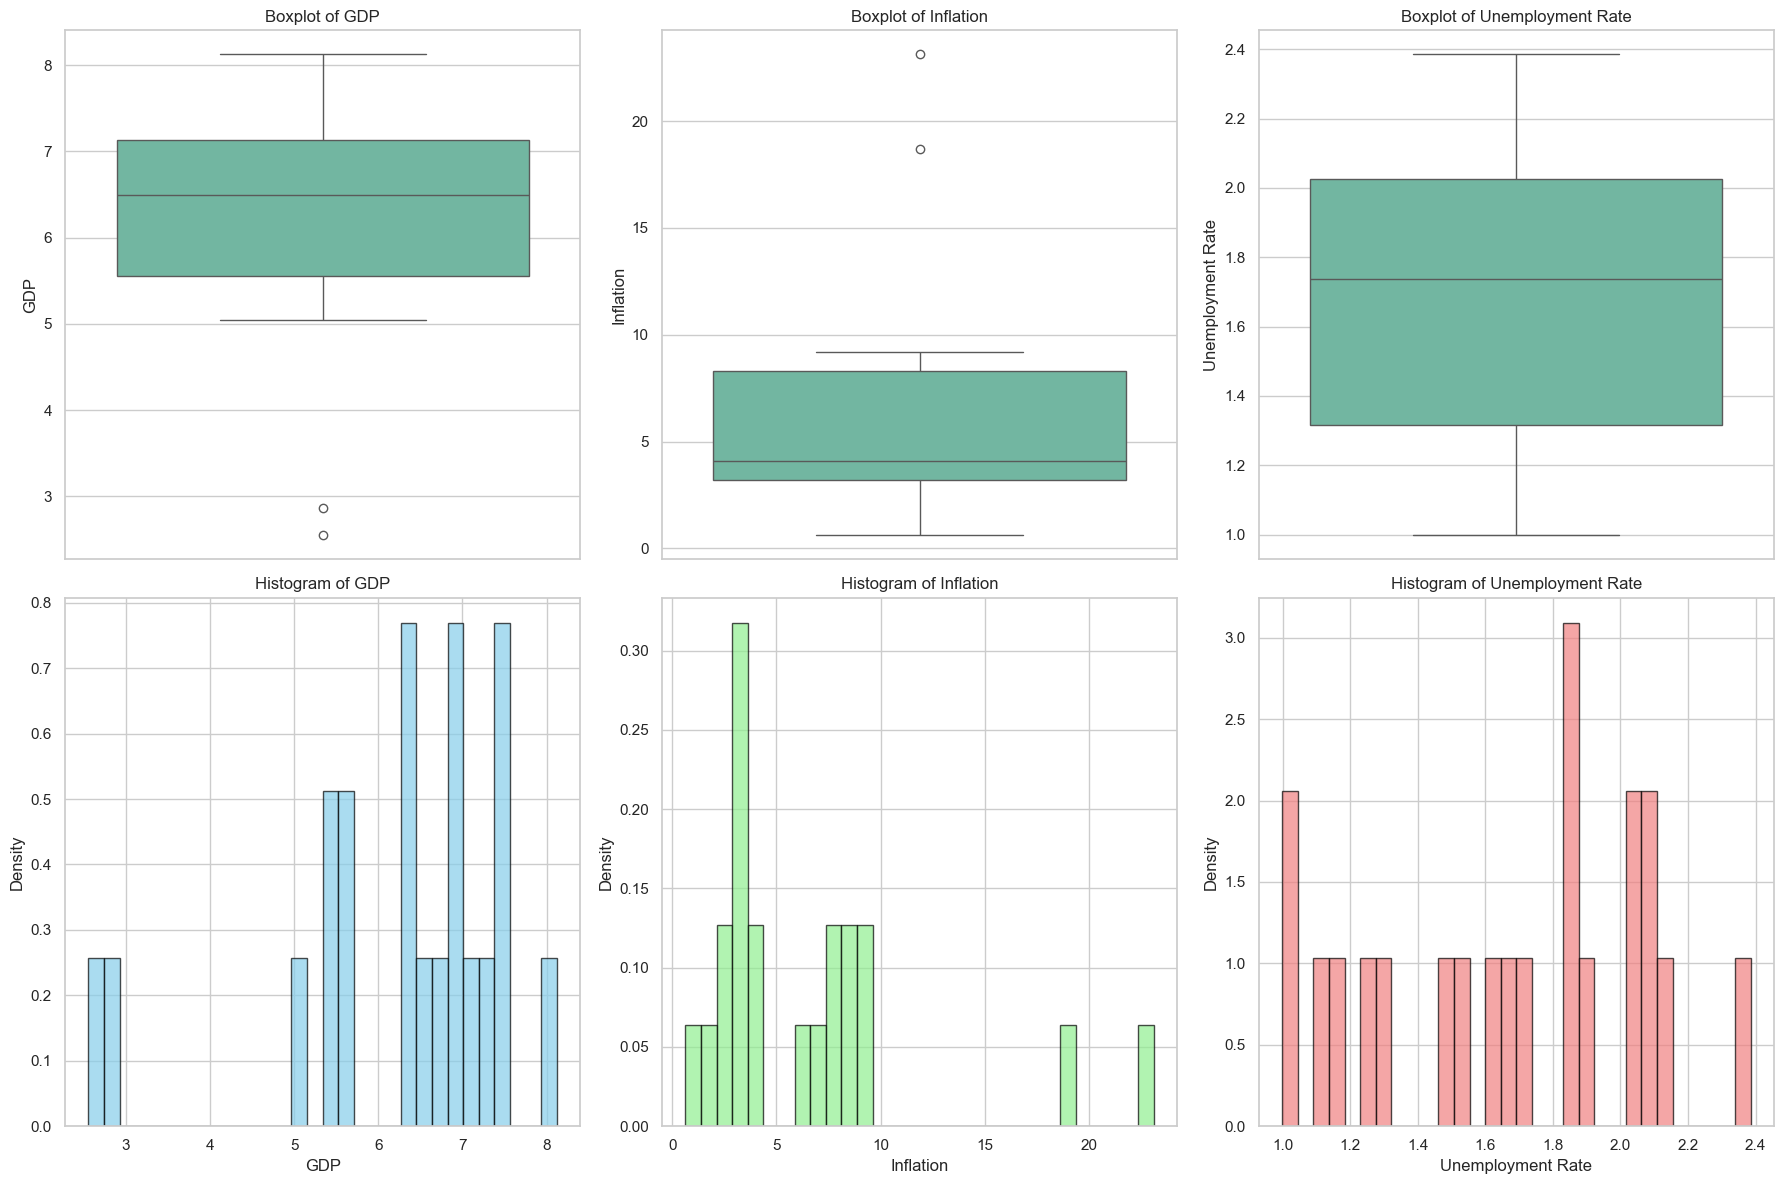

In [78]:
# Draw histogram and boxplot

# Set the style of the plots
sns.set(style="whitegrid")

# Create a figure with 2 rows and 3 columns (6 subplots)
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# 1st row: Boxplots
sns.boxplot(data=df_macroeconomics['GDP'], ax=axs[0, 0], palette="Set2")
axs[0, 0].set_title('Boxplot of GDP')
axs[0, 0].set_ylabel('GDP')

sns.boxplot(data=df_macroeconomics['Inflation'], ax=axs[0, 1], palette="Set2")
axs[0, 1].set_title('Boxplot of Inflation')
axs[0, 1].set_ylabel('Inflation')

sns.boxplot(data=df_macroeconomics['Unemployment_rate'], ax=axs[0, 2], palette="Set2")
axs[0, 2].set_title('Boxplot of Unemployment Rate')
axs[0, 2].set_ylabel('Unemployment Rate')

# 2nd row: Histograms
axs[1, 0].hist(df_macroeconomics['GDP'], bins=30, color='skyblue', edgecolor='black', alpha=0.7, density=True)
axs[1, 0].set_title('Histogram of GDP')
axs[1, 0].set_xlabel('GDP')
axs[1, 0].set_ylabel('Density')
axs[1, 0].grid(True)

axs[1, 1].hist(df_macroeconomics['Inflation'], bins=30, color='lightgreen', edgecolor='black', alpha=0.7, density=True)
axs[1, 1].set_title('Histogram of Inflation')
axs[1, 1].set_xlabel('Inflation')
axs[1, 1].set_ylabel('Density')
axs[1, 1].grid(True)

axs[1, 2].hist(df_macroeconomics['Unemployment_rate'], bins=30, color='lightcoral', edgecolor='black', alpha=0.7, density=True)
axs[1, 2].set_title('Histogram of Unemployment Rate')
axs[1, 2].set_xlabel('Unemployment Rate')
axs[1, 2].set_ylabel('Density')
axs[1, 2].grid(True)

# Adjust the layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


                        GDP  Inflation  Unemployment_rate
GDP                1.000000   0.037885          -0.223685
Inflation          0.037885   1.000000          -0.202432
Unemployment_rate -0.223685  -0.202432           1.000000


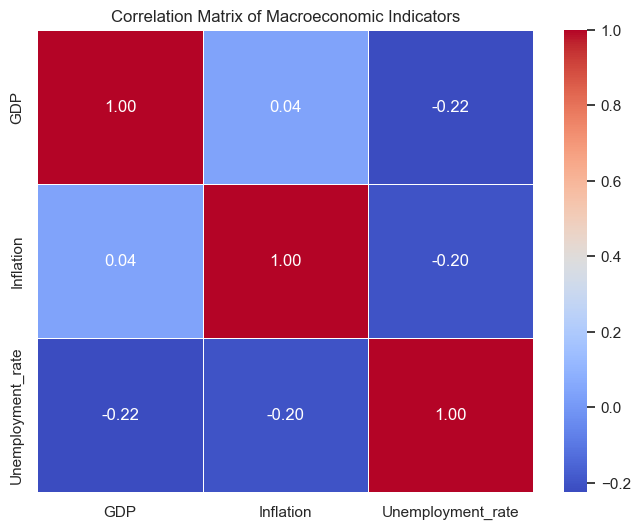

In [79]:
# Calculate the correlation matrix
correlation_matrix = df_macroeconomics[['GDP', 'Inflation', 'Unemployment_rate']].corr()

# Display the correlation matrix
print(correlation_matrix)

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Macroeconomic Indicators')
plt.show()

# 1.2 Analysis

In [81]:
# Descriptive statistics
print(df_macroeconomics.describe()) 

             GDP  Inflation  Unemployment_rate
count  21.000000  21.000000          21.000000
mean    6.242772   6.568274           1.674476
std     1.430005   5.450223           0.405616
min     2.553729   0.631201           0.999000
25%     5.553511   3.220934           1.316000
50%     6.500000   4.084554           1.737000
75%     7.129504   8.284572           2.026000
max     8.123514  23.115448           2.385000


In [82]:
# Insight:
'''' 
Based on descriptive statistics, Vietnam's average GDP growth rate is 6.2%, the average inflation rate is 6.5%, and the average unemployment
rate is 1.67%. The average inflation rate is higher than the GDP growth rate, which is typical for a developing economy like Vietnam. The high standard 
deviation in inflation indicates significant fluctuations in recent years, likely driven by special events that have impacted the economy

''''

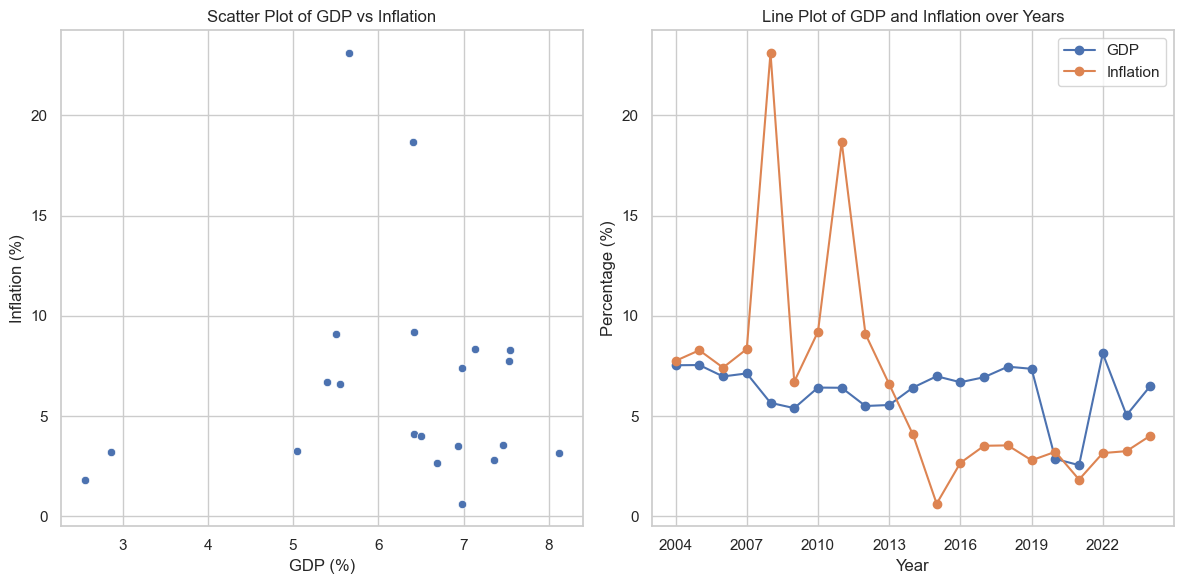

In [83]:
# Chart evaluating GDP and inflation

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Scatter plot to visualize the correlation
sns.scatterplot(data=df_macroeconomics, x='GDP', y='Inflation', ax=axs[0])
axs[0].set_title('Scatter Plot of GDP vs Inflation')
axs[0].set_xlabel('GDP (%)')
axs[0].set_ylabel('Inflation (%)')
axs[0].grid(True)

# Plot 2: Line plot for GDP and Inflation over time
years = list(range(2004, 2025))  # Giả định có 20 năm dữ liệu
axs[1].plot(years, df_macroeconomics['GDP'], label='GDP', marker='o')
axs[1].plot(years, df_macroeconomics['Inflation'], label='Inflation', marker='o')
axs[1].set_title('Line Plot of GDP and Inflation over Years')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Percentage (%)')

# Set x-axis ticks every 3 years
axs[1].set_xticks(list(range(2004, 2025, 3)))

axs[1].legend()
axs[1].grid(True)

# Hiển thị tất cả các biểu đồ
plt.tight_layout()
plt.show()


In [84]:
# Insight: 
''''
    
''''

D:\Anacoda\Anacoda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anacoda\Anacoda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anacoda\Anacoda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anacoda\Anacoda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there a

KMeans clustering result:
           GDP  Inflation  Unemployment_rate  Cluster
Year                                                 
2004  0.926979   0.223106           1.176039        2
2005  0.934745   0.322681           1.016884        2
2006  0.526808   0.159760           0.936043        2
2007  0.635404   0.333938           0.888044        2
2008 -0.416326   3.111030           0.541945        0
2009 -0.605409   0.027959           0.157952        1
2010  0.129321   0.496194          -1.415914        1
2011  0.122101   2.276696          -1.706435        0
2012 -0.528989   0.474993          -1.635700        1
2013 -0.493902   0.004588          -0.905608        1
2014  0.128603  -0.466964          -1.057184        1
2015  0.533400  -1.116228           0.440894        2
2016  0.320475  -0.733243           0.438368        2
2017  0.499747  -0.573057           0.504051        2
2018  0.875814  -0.569415          -1.297180        1
2019  0.800041  -0.709257           0.016481        2
20

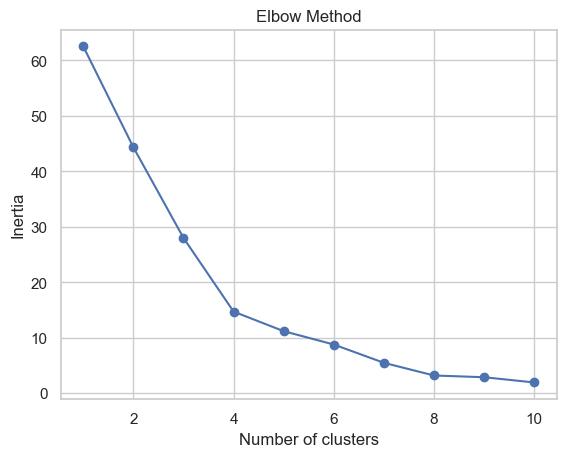

In [85]:
# Using clustering for grouping data
# Standardize using Z-score

scaler = StandardScaler()
df_zscore_scaled = pd.DataFrame(scaler.fit_transform(df_macroeconomics), columns=df_macroeconomics.columns, index=df_macroeconomics.index)
df_zscore_scaled= df_zscore_scaled[df_zscore_scaled.index <2024]
# Apply KMeans clustering algorithm
kmeans = KMeans(n_clusters=4, random_state=42)  # Try with 4 clusters
df_zscore_scaled['Cluster'] = kmeans.fit_predict(df_zscore_scaled)

# Print clustering results
print("KMeans clustering result:")
print(df_zscore_scaled)

# Evaluate the clustering
# Silhouette Score: Measures how similar each sample is to its own cluster compared to other clusters
sil_score = silhouette_score(df_zscore_scaled[df_macroeconomics.columns], kmeans.labels_)
print(f'Silhouette Score: {sil_score}')

# Davies-Bouldin Index: Measures the average similarity ratio of each cluster with the other clusters
db_index = davies_bouldin_score(df_zscore_scaled[df_macroeconomics.columns], kmeans.labels_)
print(f'Davies-Bouldin Index: {db_index}')

# Inertia (SSE): Measures the sum of squared distances from each point to its assigned cluster center
inertia = kmeans.inertia_
print(f'Inertia: {inertia}')

# Plot the Elbow Method to determine the optimal number of clusters
inertia_values = []
for k in range(1, 11):  # Try with 1 to 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_zscore_scaled[df_macroeconomics.columns])
    inertia_values.append(kmeans.inertia_)

# Plot the inertia values for different numbers of clusters
plt.plot(range(1, 11), inertia_values, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [86]:
# Insight:

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_35504\4190986327.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='GDP', data=df_macroeconomics, palette='Set2', ax=axs[0])
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_35504\4190986327.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Inflation', data=df_macroeconomics, palette='Set2', ax=axs[1])


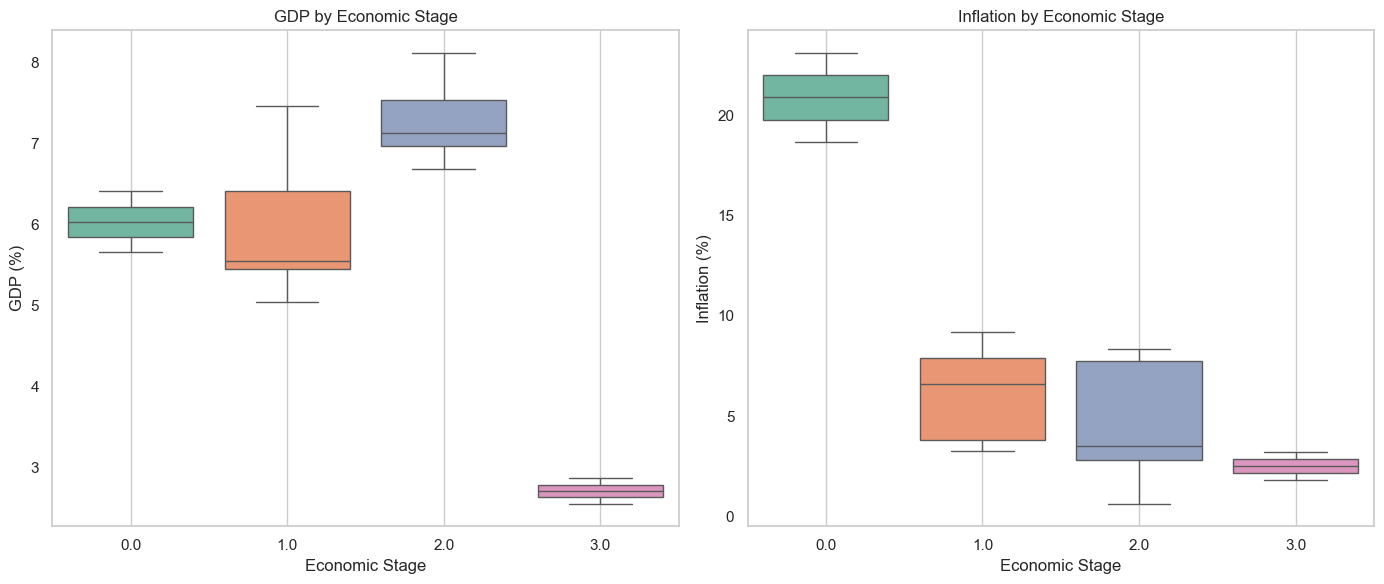

In [87]:
# Group data by economic stages (clusters)
df_macroeconomics['Cluster'] = df_zscore_scaled['Cluster']  
grouped = df_macroeconomics.groupby('Cluster')

# Calculate mean and standard deviation for each group
summary_stats = grouped.agg(['mean', 'std'])

# 4.4 Data Visualization
fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # Create a 1-row, 2-column grid

# Box plot for GDP by economic stage
sns.boxplot(x='Cluster', y='GDP', data=df_macroeconomics, palette='Set2', ax=axs[0])
axs[0].set_title('GDP by Economic Stage')
axs[0].set_ylabel('GDP (%)')
axs[0].set_xlabel('Economic Stage')
axs[0].grid()

# Box plot for Inflation by economic stage
sns.boxplot(x='Cluster', y='Inflation', data=df_macroeconomics, palette='Set2', ax=axs[1])
axs[1].set_title('Inflation by Economic Stage')
axs[1].set_ylabel('Inflation (%)')
axs[1].set_xlabel('Economic Stage')
axs[1].grid()

# Display the plots
plt.tight_layout()
plt.show()


In [88]:
# Insight:

In [89]:
# Labeling

df_macroeconomics['Stage'] = df_macroeconomics['Cluster'].map({
    0: 'Trough',
    1: 'Recovery',
    2: 'Peak',
    3: 'Recession'
})
df_macroeconomics.drop(['Cluster'], axis=1, inplace=True)
df_macroeconomics = df_macroeconomics[df_macroeconomics.index < 2024]

In [90]:
# Using ANOVA test to determine whether different between Stage
df_macroeconomics=df_macroeconomics.join(df_VNINDEX)

# Grouping by economic stage
group_peak = df_macroeconomics[df_macroeconomics['Stage'] == 'Peak']['Close']
group_recession = df_macroeconomics[df_macroeconomics['Stage'] == 'Recession']['Close']
group_recovery = df_macroeconomics[df_macroeconomics['Stage'] == 'Recovery']['Close']
group_trough =df_macroeconomics[df_macroeconomics['Stage'] == 'Trough']['Close']
# 2.2 Perform ANOVA test
f_stat, p_value = stats.f_oneway(group_peak, group_recession, group_recovery, group_trough)

# Display the results of the test
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Check the results
alpha = 0.05  # Significance level 5%
if p_value < alpha:
    print("Reject the null hypothesis (H0): There is a difference between the stages.")
else:
    print("Fail to reject the null hypothesis (H0): No difference between the stages.")

F-statistic: 4.5883
P-value: 0.0168
Reject the null hypothesis (H0): There is a difference between the stages.


In [91]:
# Insight:

In [92]:
# Check correlation between variables 
df_macroeconomics['% Price change'] = (df_macroeconomics['Close'] - df_macroeconomics['Close'].shift(1)) / df_macroeconomics['Close'].shift(1)*100
correlation_matrix = df_macroeconomics[['Close', 'GDP', 'Inflation',]].corr()
print(correlation_matrix)
# Now group by and perform aggregation
grouped = df_macroeconomics.groupby('Stage')
summary_stats = grouped.agg(['mean', 'std'])
summary_stats

              Close       GDP  Inflation
Close      1.000000 -0.408794  -0.597805
GDP       -0.408794  1.000000   0.042577
Inflation -0.597805  0.042577   1.000000


GDP            Inflation           Unemployment_rate  \
               mean       std       mean       std              mean   
Stage                                                                  
Peak       7.254583  0.434792   4.952669  2.965639          1.897222   
Recession  2.709571  0.220394   2.527825  0.980205          2.244000   
Recovery   5.973268  0.838184   6.069843  2.515458          1.316143   
Trough     6.037470  0.531318  20.896590  3.137939          1.444000   

                           Close             % Price change             
                std         mean         std           mean        std  
Stage                                                                   
Peak       0.197778   713.533333  291.109964      30.020188  51.711248  
Recession  0.199404  1301.075000  278.889986      25.298876  14.751485  
Recovery   0.261721   637.984286  266.905267      15.054515  21.356917  
Trough     0.629325   333.585000   25.406347     -46.708942  27.215589

In [93]:
# Insight

In [94]:
# Removing abnormal value
filtered_df = df_macroeconomics[df_macroeconomics.index != 2006]
# Now group by and perform aggregation
grouped = filtered_df.groupby('Stage')
summary_stats = grouped.agg(['mean', 'std'])
summary_stats

GDP            Inflation           Unemployment_rate  \
               mean       std       mean       std              mean   
Stage                                                                  
Peak       7.289162  0.451389   4.644501  3.012413          1.878750   
Recession  2.709571  0.220394   2.527825  0.980205          2.244000   
Recovery   5.973268  0.838184   6.069843  2.515458          1.316143   
Trough     6.037470  0.531318  20.896590  3.137939          1.444000   

                           Close             % Price change             
                std         mean         std           mean        std  
Stage                                                                   
Peak       0.202964   708.753750  310.831901      13.669065  24.987516  
Recession  0.199404  1301.075000  278.889986      25.298876  14.751485  
Recovery   0.261721   637.984286  266.905267      15.054515  21.356917  
Trough     0.629325   333.585000   25.406347     -46.708942  27.215589

In [95]:
# Insight

In [96]:
# Comparing VNINDEX and DOWJONE (data)

# VNINDEX data
df_VNINDEX_raw1= pd.read_csv(r"C:\Users\ADMIN\OneDrive - Trường ĐH CNTT - University of Information Technology\effort\ki1_nam3\Phân tích thống kê\Đồ án\VNINDEX-20222024.csv")
# Rename columns
df_VNINDEX_raw1=df_VNINDEX_raw1.rename(columns={'Ngày':'Date','Lần cuối':'Close','Mở':'Open','Cao':'High','Thấp':'Low','KL':'Volumne','% Thay đổi':'Change %'})
df_VNINDEX_raw1['Date'] = pd.to_datetime(df_VNINDEX_raw1['Date'], format='%d/%m/%Y')
# Converting numerical columns from strings to numbers, handling commas
df_VNINDEX_raw1['Close'] = pd.to_numeric(df_VNINDEX_raw1['Close'].str.replace(',', '', regex=True), errors='coerce')
df_VNINDEX_raw1['Open'] = pd.to_numeric(df_VNINDEX_raw1['Open'].str.replace(',', '', regex=True), errors='coerce')
df_VNINDEX_raw1['High'] = pd.to_numeric(df_VNINDEX_raw1['High'].str.replace(',', '', regex=True), errors='coerce')
df_VNINDEX_raw1['Low'] = pd.to_numeric(df_VNINDEX_raw1['Low'].str.replace(',', '', regex=True), errors='coerce')
# Converting 'Change %' column by removing '%' symbol
df_VNINDEX_raw1['Change %'] = pd.to_numeric(
    df_VNINDEX_raw1['Change %'].str.replace('%', '', regex=False).str.replace(',', '', regex=True),
    errors='coerce')
# Define a function to convert 'Volumne' values
def convert_to_number(value):
    if isinstance(value, str):
        value = value.replace(',', '')  # Remove commas
        if 'M' in value:
            return float(value.replace('M', '')) * 1_000_000
        elif 'K' in value:
            return float(value.replace('K', '')) * 1_000
        elif 'B' in value:
            return float(value.replace('B', '')) * 1_000_000_000
    return pd.to_numeric(value, errors='coerce')  # Convert remaining values to numeric

# Apply the conversion function to 'Volumne' column
df_VNINDEX_raw1['Volumne'] = df_VNINDEX_raw1['Volumne'].apply(convert_to_number)

# Display DataFrame info to verify changes
df_VNINDEX_raw1.info()
df_VNINDEX_raw1.tail(5)
# VNINDEX data
df_DowJone_raw1= pd.read_csv(r"C:\Users\ADMIN\OneDrive - Trường ĐH CNTT - University of Information Technology\effort\ki1_nam3\Phân tích thống kê\Đồ án\DowJone20222024.csv")
# Rename columns
df_DowJone_raw1=df_DowJone_raw1.rename(columns={'Ngày':'Date','Lần cuối':'Close','Mở':'Open','Cao':'High','Thấp':'Low','KL':'Volumne','% Thay đổi':'Change %'})
df_DowJone_raw1['Date'] = pd.to_datetime(df_DowJone_raw1['Date'], format='%d/%m/%Y')
# Converting numerical columns from strings to numbers, handling commas
df_DowJone_raw1['Close'] = pd.to_numeric(df_DowJone_raw1['Close'].str.replace(',', '', regex=True), errors='coerce')
df_DowJone_raw1['Open'] = pd.to_numeric(df_DowJone_raw1['Open'].str.replace(',', '', regex=True), errors='coerce')
df_DowJone_raw1['High'] = pd.to_numeric(df_DowJone_raw1['High'].str.replace(',', '', regex=True), errors='coerce')
df_DowJone_raw1['Low'] = pd.to_numeric(df_DowJone_raw1['Low'].str.replace(',', '', regex=True), errors='coerce')
# Converting 'Change %' column by removing '%' symbol
df_DowJone_raw1['Change %'] = pd.to_numeric(
    df_DowJone_raw1['Change %'].str.replace('%', '', regex=False).str.replace(',', '', regex=True),
    errors='coerce')
# Define a function to convert 'Volumne' values
def convert_to_number(value):
    if isinstance(value, str):
        value = value.replace(',', '')  # Remove commas
        if 'M' in value:
            return float(value.replace('M', '')) * 1_000_000
        elif 'K' in value:
            return float(value.replace('K', '')) * 1_000
        elif 'B' in value:
            return float(value.replace('B', '')) * 1_000_000_000
    return pd.to_numeric(value, errors='coerce')  # Convert remaining values to numeric

# Apply the conversion function to 'Volumne' column
df_DowJone_raw1['Volumne'] = df_DowJone_raw1['Volumne'].apply(convert_to_number)

# Display DataFrame info to verify changes
df_DowJone_raw1.info()
df_DowJone_raw1.tail(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707 entries, 0 to 706
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      707 non-null    datetime64[ns]
 1   Close     707 non-null    float64       
 2   Open      707 non-null    float64       
 3   High      707 non-null    float64       
 4   Low       707 non-null    float64       
 5   Volumne   706 non-null    float64       
 6   Change %  707 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 38.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      713 non-null    datetime64[ns]
 1   Close     713 non-null    float64       
 2   Open      713 non-null    float64       
 3   High      713 non-null    float64       
 4   Low       713 non-null    float64    

,Date,Close,Open,High,Low,Volumne,Change %
698,2022-01-31,35131.86,34691.17,35148.14,34496.10,474440000.0,1.17
699,2022-01-28,34725.47,34135.24,34731.77,33807.51,568440000.0,1.65
700,2022-01-27,34160.78,34261.75,34773.32,34007.78,527780000.0,-0.02
701,2022-01-26,34168.09,34520.82,34815.67,33876.48,549310000.0,-0.38
702,2022-01-25,34297.73,34186.64,34591.04,33545.52,522190000.0,-0.19
703,2022-01-24,34364.50,34070.61,34420.99,33150.33,678120000.0,0.29
704,2022-01-21,34265.37,34701.69,34896.67,34229.55,523880000.0,-1.30
705,2022-01-20,34715.39,35102.66,35490.20,34670.12,369070000.0,-0.89
706,2022-01-19,35028.65,35412.30,35547.83,35015.49,393080000.0,-0.96
707,2022-01-18,35368.47,35661.76,35661.76,35262.02,427260000.0,-1.51


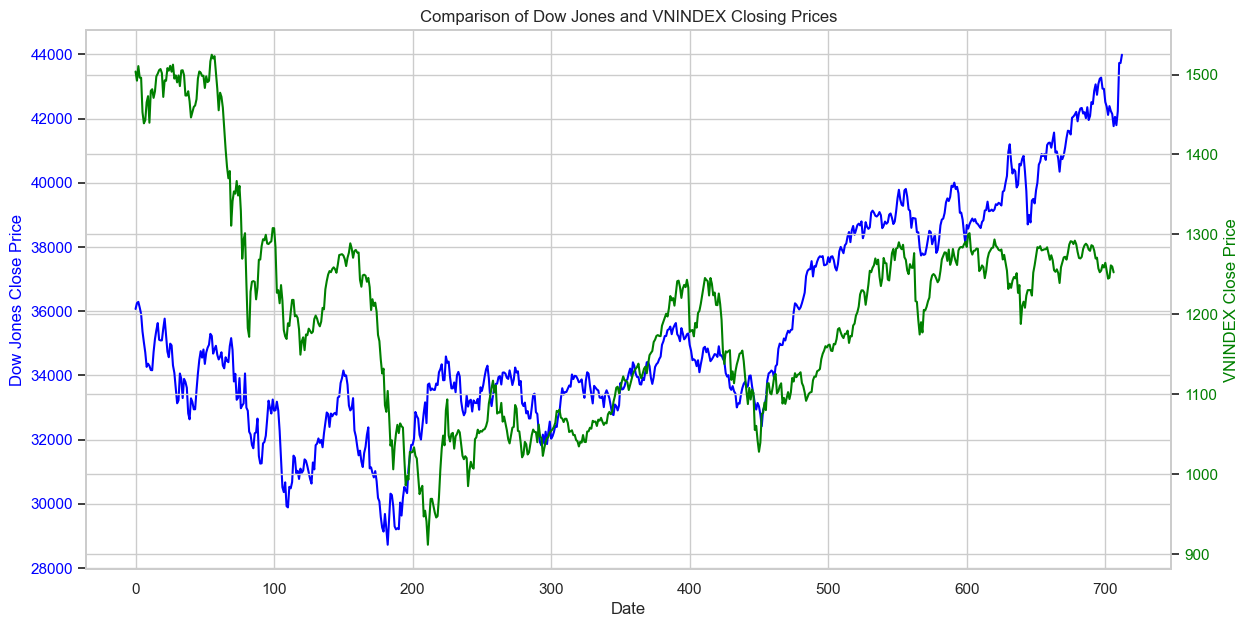

In [97]:
# Comparing VNINDEX and DOWJONE (chart)

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot the Dow Jones data with reversed order
ax1.plot(df_DowJone_raw1.index[::-1], df_DowJone_raw1['Close'], label='Dow Jones Close Price', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Dow Jones Close Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot the VNINDEX data with reversed order on the second y-axis
ax2 = ax1.twinx()
ax2.plot(df_VNINDEX_raw1.index[::-1], df_VNINDEX_raw1['Close'], label='VNINDEX Close Price', color='green')
ax2.set_ylabel('VNINDEX Close Price', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add title
plt.title('Comparison of Dow Jones and VNINDEX Closing Prices')

# Show plot
plt.show()

In [98]:
# Insight: 

# 2. Applying machine learning models to analyze bank stock prices

## 2.2 Randomforest combine Simple Regression

### 2.2.1 Exploratory Data Analyst

#### Preparing data

In [103]:
# VCB data
df_VCB_raw= pd.read_csv(r"C:\Users\ADMIN\OneDrive - Trường ĐH CNTT - University of Information Technology\effort\ki1_nam3\Phân tích thống kê\Đồ án\VCB.csv")
# Rename columns
df_VCB_raw=df_VCB_raw.rename(columns={'Ngày':'Date','Lần cuối':'Close','Mở':'Open','Cao':'High','Thấp':'Low','KL':'Volumne','% Thay đổi':'Change %'})
df_VCB_raw['Date'] = pd.to_datetime(df_VCB_raw['Date'], format='%d/%m/%Y')
# Converting numerical columns from strings to numbers, handling commas
df_VCB_raw['Close'] = pd.to_numeric(df_VCB_raw['Close'].str.replace(',', '', regex=True), errors='coerce')
df_VCB_raw['Open'] = pd.to_numeric(df_VCB_raw['Open'].str.replace(',', '', regex=True), errors='coerce')
df_VCB_raw['High'] = pd.to_numeric(df_VCB_raw['High'].str.replace(',', '', regex=True), errors='coerce')
df_VCB_raw['Low'] = pd.to_numeric(df_VCB_raw['Low'].str.replace(',', '', regex=True), errors='coerce')
# Converting 'Change %' column by removing '%' symbol
df_VCB_raw['Change %'] = pd.to_numeric(
    df_VCB_raw['Change %'].str.replace('%', '', regex=False).str.replace(',', '', regex=True),
    errors='coerce')
# Define a function to convert 'Volumne' values
def convert_to_number(value):
    if isinstance(value, str):
        value = value.replace(',', '')  # Remove commas
        if 'M' in value:
            return float(value.replace('M', '')) * 1_000_000
        elif 'K' in value:
            return float(value.replace('K', '')) * 1_000
        elif 'B' in value:
            return float(value.replace('B', '')) * 1_000_000_000
    return pd.to_numeric(value, errors='coerce')  # Convert remaining values to numeric

# Apply the conversion function to 'Volumne' column
df_VCB_raw['Volumne'] = df_VCB_raw['Volumne'].apply(convert_to_number)

# Display DataFrame info to verify changes
df_VCB_raw.info()
df_VCB_raw = df_VCB_raw.ffill()
df_VCB_raw.set_index('Date', inplace=True)
df_VCB_raw = df_VCB_raw.sort_index(ascending=True)
df_VCB_raw 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207 entries, 0 to 1206
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1207 non-null   datetime64[ns]
 1   Close     1207 non-null   int64         
 2   Open      1207 non-null   int64         
 3   High      1207 non-null   int64         
 4   Low       1207 non-null   int64         
 5   Volumne   1206 non-null   float64       
 6   Change %  1207 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 66.1 KB


,Close,Open,High,Low,Volumne,Change %
Date,,,,,,
2020-01-02,69728,69267,70189,68883,492910.0,0.67
2020-01-03,69037,70265,70496,69037,684100.0,-0.99
2020-01-06,67194,68499,68730,67194,1120000.0,-2.67
2020-01-07,67424,66810,67501,65581,1290000.0,0.34
2020-01-08,66810,66733,67501,66195,921630.0,-0.91
...,...,...,...,...,...,...
2024-10-25,91800,92100,92300,91700,1050000.0,0.11
2024-10-28,92000,91500,92300,91500,1130000.0,0.22
2024-10-29,92000,92100,92600,92000,1400000.0,0.00


In [104]:
# Combing data 
df_macroeconomics_main = df_macroeconomics[['GDP','Inflation','Unemployment_rate']]
df_macroeconomics_main
data_arimax = df_VCB_raw
data_arimax['Year'] = data_arimax.index.year
data_arimax =data_arimax.merge(df_macroeconomics_main, left_on='Year', right_index=True, how='left')
data_arimax = data_arimax[['Close','GDP','Inflation','Unemployment_rate']]
data_arimax = data_arimax.sort_index(ascending=True)
df_interest = pd.read_excel(r"C:\Users\ADMIN\OneDrive - Trường ĐH CNTT - University of Information Technology\effort\ki1_nam3\Phân tích thống kê\Đồ án\Rate.xlsx")
df_interest['Date'] = pd.to_datetime(df_interest['Year'].astype(str) + df_interest['Month'].astype(str).str.zfill(2), format='%Y%m')
df_interest.set_index('Date', inplace=True)
df_interest.drop(columns=['Year', 'Month'], inplace=True)
df_interest.tail(20)
data_arimax['Rate'] = data_arimax.index.to_period('M').map(
    lambda date: df_interest['Rate'].get(date.to_timestamp(), None)
)

#### Check basic infomation

In [106]:
# Check basic infomation of data
print(data_arimax.info())

# Check null value
print(data_arimax.isnull().sum())

# Descriptive statistics
print(data_arimax.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1207 entries, 2020-01-02 to 2024-10-31
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Close              1207 non-null   int64  
 1   GDP                1000 non-null   float64
 2   Inflation          1000 non-null   float64
 3   Unemployment_rate  1000 non-null   float64
 4   Rate               1207 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 56.6 KB
None
Close                  0
GDP                  207
Inflation            207
Unemployment_rate    207
Rate                   0
dtype: int64
              Close          GDP    Inflation  Unemployment_rate         Rate
count   1207.000000  1000.000000  1000.000000        1000.000000  1207.000000
mean   76395.287490     4.639833     2.866295           1.907319     4.000961
std    11025.415788     2.224721     0.596888           0.352912     2.253829
min    43925.000000     2.553729  

#### Check correlation between variable

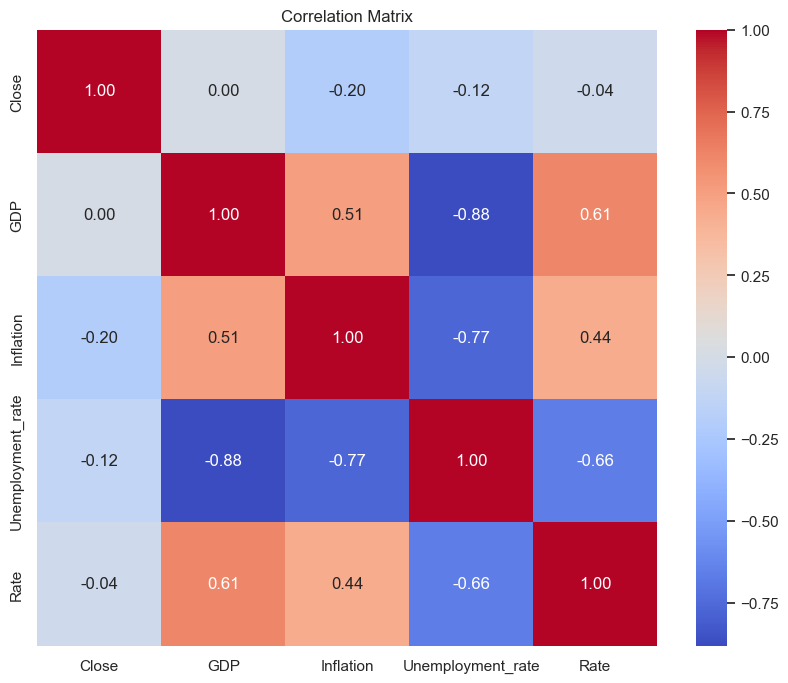

In [108]:
# Check correlation between variable
correlation_matrix = data_arimax.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

### 2.2.2 Apply Simple Regression

#### Check lag correlation

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_35504\530222734.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Lag', y='Correlation', data=correlation_df, palette='coolwarm')


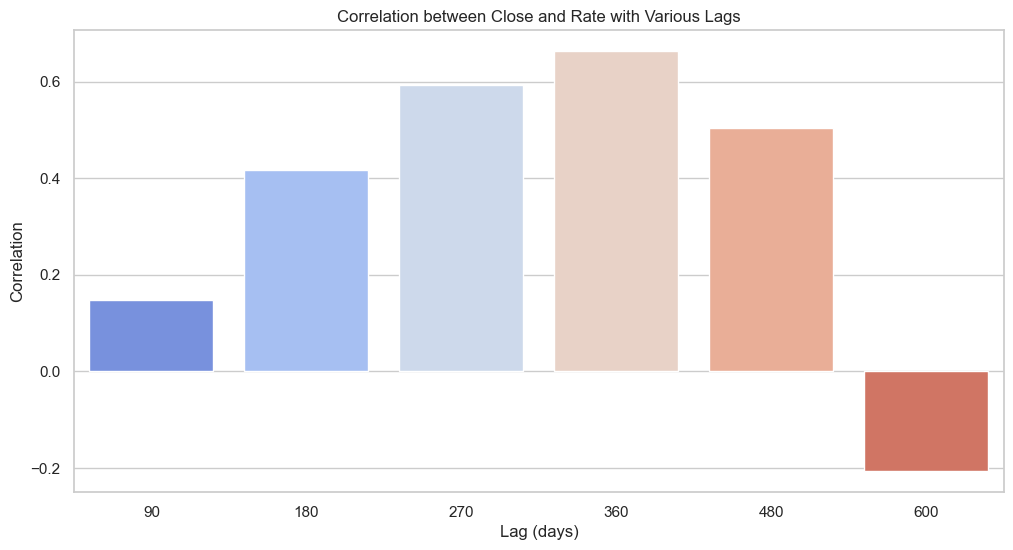

In [165]:
# Lag for Rate
data_test = data_arimax.copy()
# Create a list of lags (multiples of 30)
lags = [90, 180, 270, 360, 480, 600]
correlations = []

# Calculate the correlation between 'Close' and 'Rate' for each lag
for lag in lags:
    data_test[f'Rate_lag_{lag}'] = data_test['Rate'].shift(lag)
    correlation = data_test[['Close', f'Rate_lag_{lag}']].corr().iloc[0, 1]
    correlations.append((lag, correlation))

# Convert the list of correlations into a DataFrame for easy plotting
correlation_df = pd.DataFrame(correlations, columns=['Lag', 'Correlation'])

# Plot the correlation with various lags
plt.figure(figsize=(12, 6))
sns.barplot(x='Lag', y='Correlation', data=correlation_df, palette='coolwarm')
plt.title('Correlation between Close and Rate with Various Lags')
plt.xlabel('Lag (days)')
plt.ylabel('Correlation')
plt.show()


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_35504\3042296379.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Lag', y='Correlation', data=correlation_df, palette='coolwarm')


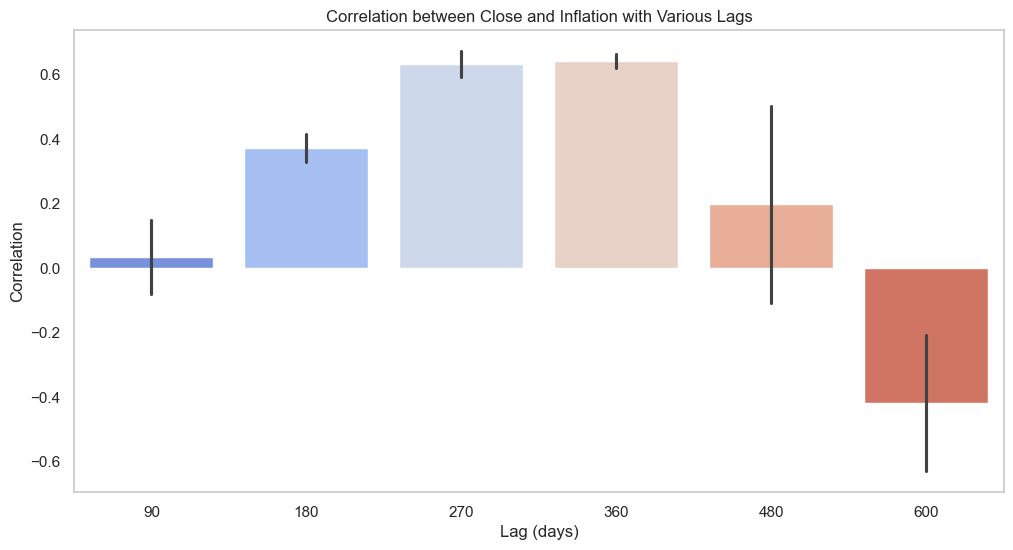

In [112]:
# Lag for inflation
# Calculate the correlation between 'Close' and 'Inflation' for each lag
for lag in lags:
    data_test[f'Inflation_lag_{lag}'] = data_test['Inflation'].shift(lag)
    correlation = data_test[['Close', f'Inflation_lag_{lag}']].corr().iloc[0, 1]
    correlations.append((lag, correlation))

# Convert the list of correlations into a DataFrame for easy plotting

correlation_df = pd.DataFrame(correlations, columns=['Lag', 'Correlation'])
# Plot the correlation with various lags
plt.figure(figsize=(12, 6))
sns.barplot(x='Lag', y='Correlation', data=correlation_df, palette='coolwarm')
plt.title('Correlation between Close and Inflation with Various Lags')
plt.xlabel('Lag (days)')
plt.ylabel('Correlation')

# Remove grid lines if needed
plt.grid(False)

plt.show()


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_35504\3005835995.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Lag', y='Correlation', data=correlation_df, palette='coolwarm')


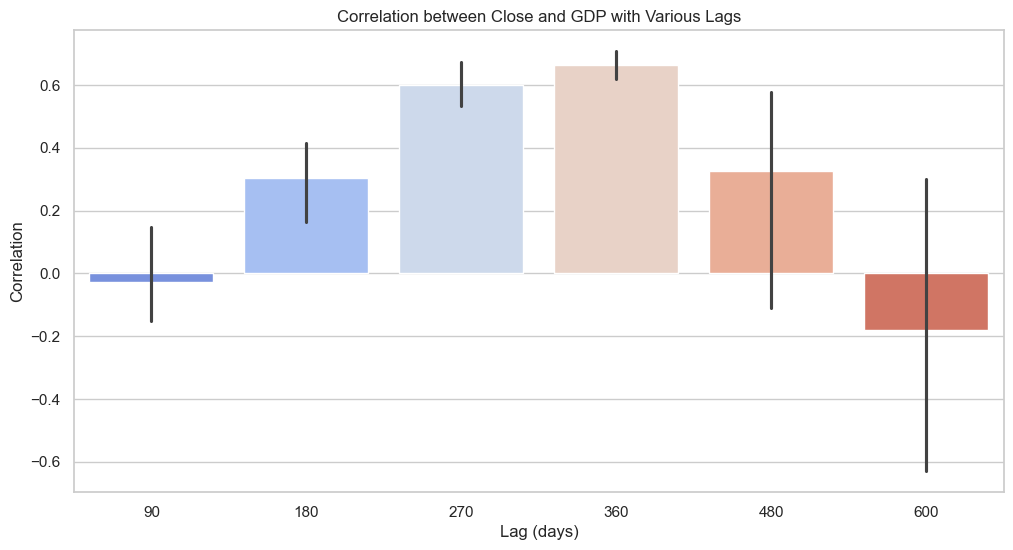

In [113]:
# Lag for GDP
# Calculate the correlation between 'Close' and 'GDP' for each lag
for lag in lags:
    data_test[f'GDP_lag_{lag}'] = data_test['GDP'].shift(lag)
    correlation = data_test[['Close', f'GDP_lag_{lag}']].corr().iloc[0, 1]
    correlations.append((lag, correlation))

# Convert the list of correlations into a DataFrame for easy plotting
correlation_df = pd.DataFrame(correlations, columns=['Lag', 'Correlation'])

# Plot the correlation with various lags
plt.figure(figsize=(12, 6))
sns.barplot(x='Lag', y='Correlation', data=correlation_df, palette='coolwarm')
plt.title('Correlation between Close and GDP with Various Lags')
plt.xlabel('Lag (days)')
plt.ylabel('Correlation')
plt.show()


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_35504\3277164520.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Lag', y='Correlation', data=correlation_df, palette='coolwarm')


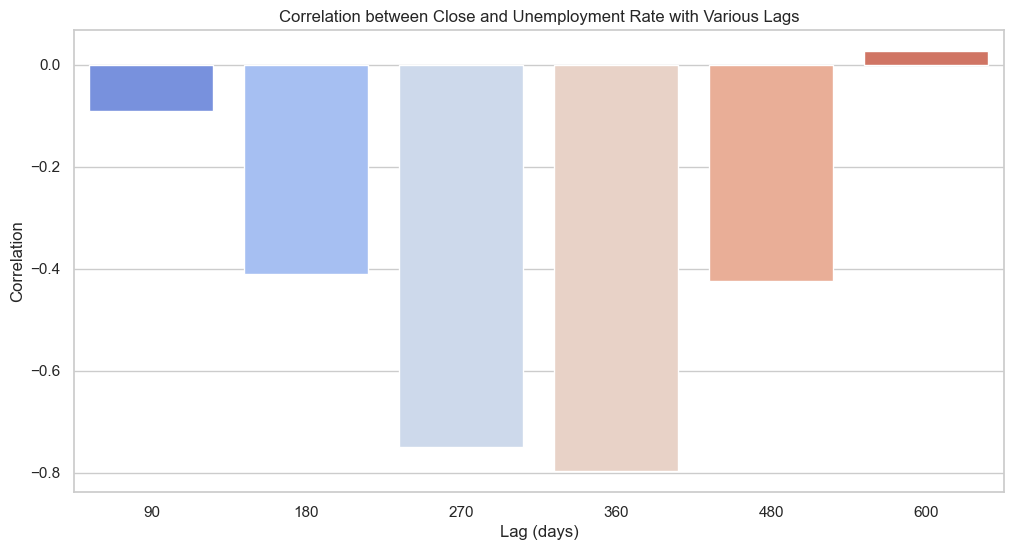

In [114]:
# Lag for Unemployment_rate
lags = [90, 180, 270, 360, 480, 600]
correlations = []

# Calculate the correlation between 'Close' and 'Unemployment_rate' for each lag
for lag in lags:
    data_test[f'Unemployment_rate_lag_{lag}'] = data_test['Unemployment_rate'].shift(lag)
    correlation = data_test[['Close', f'Unemployment_rate_lag_{lag}']].corr().iloc[0, 1]
    correlations.append((lag, correlation))

# Convert the list of correlations into a DataFrame for easy plotting
correlation_df = pd.DataFrame(correlations, columns=['Lag', 'Correlation'])

# Plot the correlation with various lags
plt.figure(figsize=(12, 6))
sns.barplot(x='Lag', y='Correlation', data=correlation_df, palette='coolwarm')
plt.title('Correlation between Close and Unemployment Rate with Various Lags')
plt.xlabel('Lag (days)')
plt.ylabel('Correlation')
plt.show()


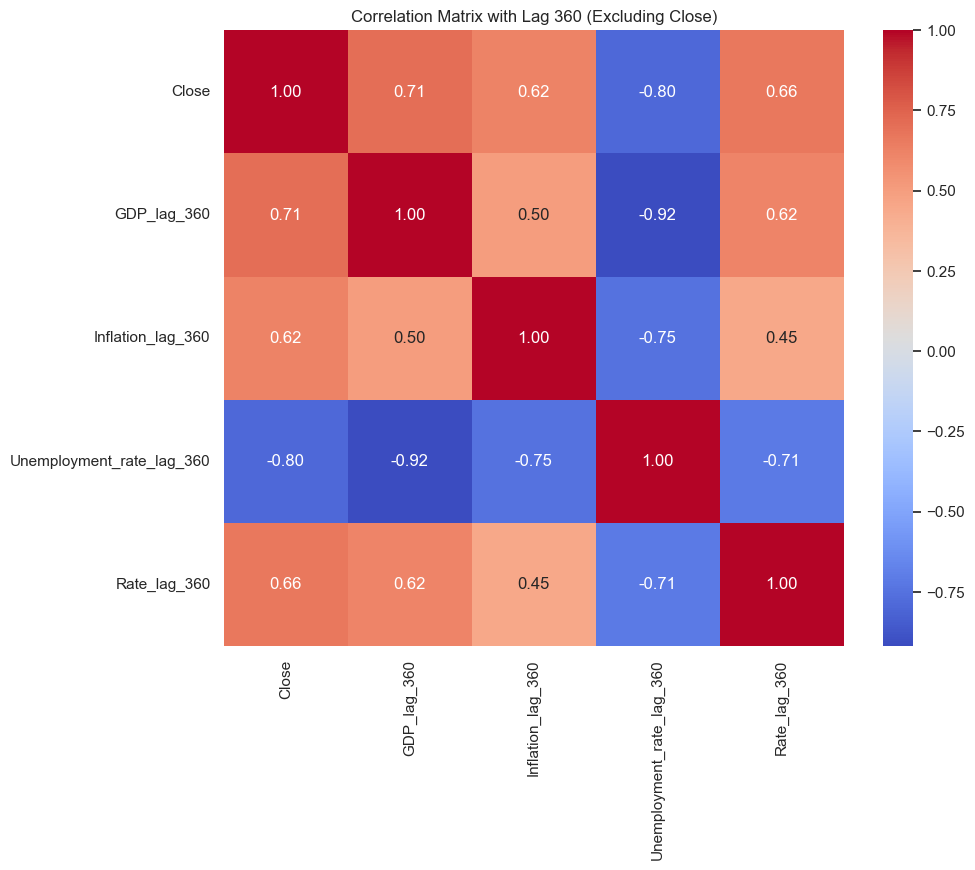

In [115]:
# Correlation with lag
# Assuming data_arimax is your DataFrame
# Create lag 360 for all columns except 'Close'
lag = 360
data_rf_lagged = data_arimax[['Close']].copy()  # Copy the 'Close' column

# Create lag 360 for all columns except 'Close'
for column in data_arimax.columns:
    if column != 'Close':
        data_rf_lagged[column + '_lag_360'] = data_arimax[column].shift(lag)

# Calculate the correlation matrix
correlation_matrix = data_rf_lagged.corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix with Lag 360 (Excluding Close)')
plt.show()



In [116]:
# Check for null (NaN) values in each column of data_arimax_lagged
null_values_per_column = data_rf_lagged.isnull().sum()

# Display the count of null values for each column
print(null_values_per_column)

Close                          0
GDP_lag_360                  360
Inflation_lag_360            360
Unemployment_rate_lag_360    360
Rate_lag_360                 360
dtype: int64


#### Replace null by using regression model

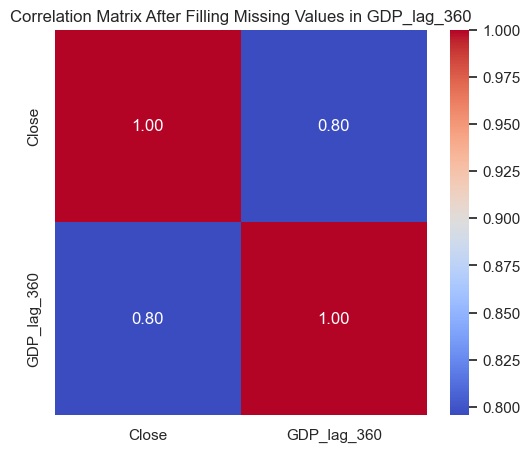

Correlation between Close and GDP_lag_360: 0.7958219030723251


In [118]:
# Replace GDP null
# Step 1: Drop rows with NaN in 'GDP_lag_360' and 'Close'
train_data =  data_rf_lagged.dropna(subset=['GDP_lag_360', 'Close'])

# Step 2: Prepare training data (X_train with 'Close', y_train with 'GDP_lag_360')
X_train = train_data[['Close']]  # Feature: Close
y_train = train_data['GDP_lag_360']  # Target: GDP_lag_360

# Step 3: Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 4: Predict missing values in 'GDP_lag_360'
missing_data =  data_rf_lagged[data_rf_lagged['GDP_lag_360'].isna()]
X_missing = missing_data[['Close']]  # Feature for missing values: Close
predictions = model.predict(X_missing)

# Step 5: Fill missing 'GDP_lag_360' values with predicted values
data_rf_lagged.loc[data_rf_lagged['GDP_lag_360'].isna(), 'GDP_lag_360'] = predictions

# Step 6: Compute correlation matrix
correlation_matrix =  data_rf_lagged[['Close', 'GDP_lag_360']].corr()

# Step 7: Plot heatmap of the correlation matrix
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix After Filling Missing Values in GDP_lag_360')
plt.show()

# Step 8: Print the correlation between 'Close' and 'GDP_lag_360' to check if it has been maintained
print(f"Correlation between Close and GDP_lag_360: {correlation_matrix.loc['Close', 'GDP_lag_360']}")


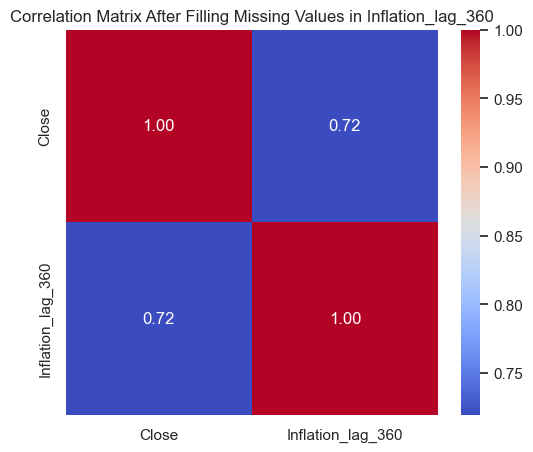

Correlation between Close and Inflation_lag_360: 0.7196688270318107


In [119]:
# Replace Inflation null
# Prepare training data for the regression model
train_data = data_rf_lagged.dropna(subset=['Inflation_lag_360', 'Close'])  # Remove rows with NaN in 'Inflation_lag_360' and 'Close'

# Create regression model
X_train = train_data[['Close']]  # Use 'Close' column as the feature
y_train = train_data['Inflation_lag_360']  # Target is 'Inflation_lag_360'

# Train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict missing values in 'Inflation_lag_360'
missing_data = data_rf_lagged[data_rf_lagged['Inflation_lag_360'].isna()]
X_missing = missing_data[['Close']]  # Feature for missing data is 'Close'
predictions = model.predict(X_missing)

# Update missing values
data_rf_lagged.loc[data_rf_lagged['Inflation_lag_360'].isna(), 'Inflation_lag_360'] = predictions

# Recompute the correlation after filling the NaN values
correlation_matrix = data_rf_lagged[['Close', 'Inflation_lag_360']].corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix After Filling Missing Values in Inflation_lag_360')
plt.show()

# Check if the correlation has been maintained
print(f"Correlation between Close and Inflation_lag_360: {correlation_matrix.loc['Close', 'Inflation_lag_360']}")


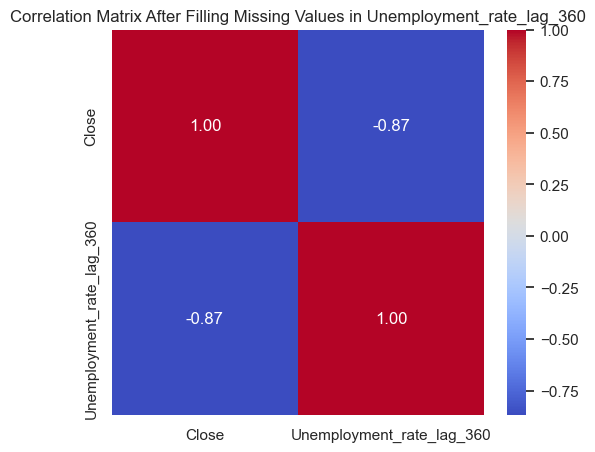

Correlation between Close and Unemployment_rate_lag_360: -0.8665155628745024


In [120]:
# Replace unemployment_rate null
# Prepare training data for the regression model
train_data = data_rf_lagged.dropna(subset=['Unemployment_rate_lag_360', 'Close'])  # Remove rows with NaN in 'Unemployment_rate_lag_360' and 'Close'

# Create the regression model
X_train = train_data[['Close']]  # Use 'Close' as the feature
y_train = train_data['Unemployment_rate_lag_360']  # Target is 'Unemployment_rate_lag_360'

# Train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the missing values in 'Unemployment_rate_lag_360'
missing_data = data_rf_lagged[data_rf_lagged['Unemployment_rate_lag_360'].isna()]
X_missing = missing_data[['Close']]  # The feature for missing data is 'Close'
predictions = model.predict(X_missing)

# Update the missing values with the predicted values
data_rf_lagged.loc[data_rf_lagged['Unemployment_rate_lag_360'].isna(), 'Unemployment_rate_lag_360'] = predictions

# Recompute the correlation after filling the NaN values
correlation_matrix = data_rf_lagged[['Close', 'Unemployment_rate_lag_360']].corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix After Filling Missing Values in Unemployment_rate_lag_360')
plt.show()

# Check if the correlation has been maintained
print(f"Correlation between Close and Unemployment_rate_lag_360: {correlation_matrix.loc['Close', 'Unemployment_rate_lag_360']}")

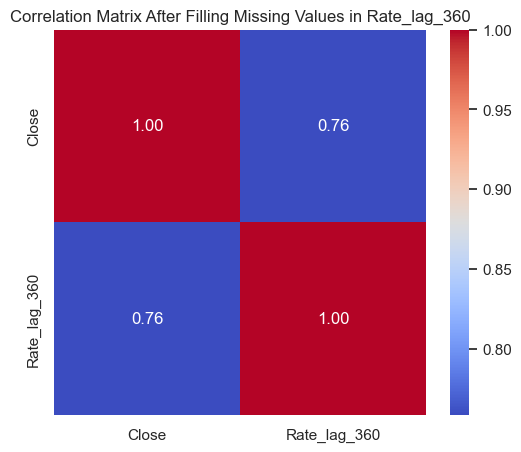

Correlation between Close and Rate_lag_360: 0.7585060584031065


In [121]:
# Replace Rate null
# Prepare training data for the regression model
train_data =  data_rf_lagged.dropna(subset=['Rate_lag_360', 'Close'])  # Remove rows with NaN in 'Rate_lag_360' and 'Close'

# Create the regression model
X_train = train_data[['Close']]  # Use 'Close' as the feature
y_train = train_data['Rate_lag_360']  # Target is 'Rate_lag_360'

# Train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the missing values in 'Rate_lag_360'
missing_data =  data_rf_lagged[data_rf_lagged['Rate_lag_360'].isna()]
X_missing = missing_data[['Close']]  # The feature for missing data is 'Close'
predictions = model.predict(X_missing)

# Update the missing values with the predicted values
data_rf_lagged.loc[data_rf_lagged['Rate_lag_360'].isna(), 'Rate_lag_360'] = predictions

# Recompute the correlation after filling the NaN values
correlation_matrix = data_rf_lagged[['Close', 'Rate_lag_360']].corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix After Filling Missing Values in Rate_lag_360')
plt.show()

# Check if the correlation has been maintained
print(f"Correlation between Close and Rate_lag_360: {correlation_matrix.loc['Close', 'Rate_lag_360']}")

In [122]:
 data_rf_lagged

,Close,GDP_lag_360,Inflation_lag_360,Unemployment_rate_lag_360,Rate_lag_360
Date,,,,,
2020-01-02,69728,2.810746,2.398674,2.255334,2.093353
2020-01-03,69037,2.693202,2.372041,2.274941,1.973277
2020-01-06,67194,2.379695,2.301008,2.327238,1.653016
2020-01-07,67424,2.418820,2.309872,2.320712,1.692984
2020-01-08,66810,2.314374,2.286207,2.338134,1.586288
...,...,...,...,...,...
2024-10-25,91800,5.046431,3.252893,1.602000,5.660000
2024-10-28,92000,5.046431,3.252893,1.602000,5.660000
2024-10-29,92000,5.046431,3.252893,1.602000,5.660000


### 2.2.3 Construct technical indicators

#### Compute technical index

In [124]:
# Compute SMA and EMA 
data_rf_lagged['SMA_100'] =  data_rf_lagged['Close'].rolling(window=100).mean()
data_rf_lagged['SMA_200'] =  data_rf_lagged['Close'].rolling(window=200).mean()
data_rf_lagged['SMA_50'] =  data_rf_lagged['Close'].rolling(window=50).mean()
data_rf_lagged['EMA_50'] =  data_rf_lagged['Close'].ewm(span=50, adjust=False).mean()
data_rf_lagged['RSI_14'] = ta.momentum.RSIIndicator( data_rf_lagged['Close'], window=14).rsi()
# Fill NAN value by mean
data_rf_lagged['SMA_100'] =  data_rf_lagged['SMA_100'].fillna( data_rf_lagged['SMA_100'].mean())
data_rf_lagged['SMA_200'] =  data_rf_lagged['SMA_200'].fillna( data_rf_lagged['SMA_200'].mean())
data_rf_lagged['SMA_50'] = data_rf_lagged['SMA_50'].fillna( data_rf_lagged['SMA_50'].mean())
data_rf_lagged['RSI_14'] =  data_rf_lagged['RSI_14'].fillna( data_rf_lagged['RSI_14'].mean())
data_rf_lagged

,Close,GDP_lag_360,Inflation_lag_360,Unemployment_rate_lag_360,Rate_lag_360,SMA_100,SMA_200,SMA_50,EMA_50,RSI_14
Date,,,,,,,,,,
2020-01-02,69728,2.810746,2.398674,2.255334,2.093353,76358.493944,76441.384707,76244.981848,69728.000000,51.265362
2020-01-03,69037,2.693202,2.372041,2.274941,1.973277,76358.493944,76441.384707,76244.981848,69700.901961,51.265362
2020-01-06,67194,2.379695,2.301008,2.327238,1.653016,76358.493944,76441.384707,76244.981848,69602.592080,51.265362
2020-01-07,67424,2.418820,2.309872,2.320712,1.692984,76358.493944,76441.384707,76244.981848,69517.157096,51.265362
2020-01-08,66810,2.314374,2.286207,2.338134,1.586288,76358.493944,76441.384707,76244.981848,69410.994073,51.265362
...,...,...,...,...,...,...,...,...,...,...
2024-10-25,91800,5.046431,3.252893,1.602000,5.660000,89338.600000,90670.800000,91141.000000,91009.582352,52.756894
2024-10-28,92000,5.046431,3.252893,1.602000,5.660000,89368.600000,90699.800000,91229.000000,91048.422260,54.565868
2024-10-29,92000,5.046431,3.252893,1.602000,5.660000,89403.600000,90725.800000,91307.000000,91085.739034,54.565868


### 2.2.4 Build Randomforest model

#### Build model

In [126]:
# Build model
# Assume data_rf_lagged is your DataFrame with lagged variables
X = data_rf_lagged[['Rate_lag_360', 'GDP_lag_360', 'Inflation_lag_360', 'Unemployment_rate_lag_360', 'SMA_200', 'SMA_100', 'SMA_50', 'EMA_50', 'RSI_14']] 
y = data_rf_lagged['Close']  # Dependent variable

# Standardize the independent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create polynomial features (degree 2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_scaled)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Create and train the Random Forest model with optimized parameters
rf_model = RandomForestRegressor(
    n_estimators=150,      # Number of trees
    max_depth=None,         # No limit on the depth of the trees
    max_features='sqrt',    # Select the smallest number of features at each split
    min_samples_leaf=4,     # Minimum of 4 samples in each leaf
    min_samples_split=2,    # Minimum of 2 samples to split a node
    random_state=42         # Ensure reproducibility
)
rf_model.fit(X_train, y_train)


RandomForestRegressor(max_features='sqrt', min_samples_leaf=4, n_estimators=150,
                      random_state=42)

#### Check result

In [128]:
# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print evaluation results
print("Random Forest - Mean Squared Error:", mse_rf)
print("Random Forest - R-squared:", r2_rf)

Random Forest - Mean Squared Error: 784648.3480378153
Random Forest - R-squared: 0.9938769259344186


In [129]:
# Insight: 

#### Check overfitting

In [131]:
# Predict on the training set
y_pred_train_rf = rf_model.predict(X_train)

# Evaluate the model on training data
mse_train_rf = mean_squared_error(y_train, y_pred_train_rf)
r2_train_rf = r2_score(y_train, y_pred_train_rf)

# Evaluate the model on test data
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print the evaluation metrics
print("Random Forest - Training R-squared:", r2_train_rf)
print("Random Forest - Test R-squared:", r2_rf)

Random Forest - Training R-squared: 0.9972682396538758
Random Forest - Test R-squared: 0.9938769259344186


### 2.2.5 Evaluate and improve the model

#### Improving model

In [133]:
# Define the parameter grid for optimization
param_grid = {
    'n_estimators': [100, 150, 200],  # Number of trees
    'max_depth': [None, 10, 20, 30],   # Maximum depth of trees
    'min_samples_split': [2, 5, 10],   # Minimum number of samples to split a node
    'min_samples_leaf': [1, 2, 4],     # Minimum number of samples in each leaf
    'max_features': ['sqrt']           # Number of features to consider for each split
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), 
                           param_grid=param_grid, 
                           cv=5,  # 5-fold cross-validation
                           scoring='neg_mean_squared_error',  # Negative MSE for scoring (higher is better)
                           n_jobs=-1, verbose=2)  # Use all available CPU cores, verbose output

# Fit the model with grid search
grid_search.fit(X_train, y_train)

# Display the best hyperparameters
print(f"Best parameters: {grid_search.best_params_}")

# Use the optimized model for predictions
best_rf_model = grid_search.best_estimator_

# Predict and evaluate on the test set
y_pred_rf_optimized = best_rf_model.predict(X_test)

# Calculate the Mean Squared Error and RMSE
mse_rf_optimized = mean_squared_error(y_test, y_pred_rf_optimized)
rmse_rf_optimized = mse_rf_optimized**0.5

print("Optimized Random Forest - RMSE:", rmse_rf_optimized)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Optimized Random Forest - RMSE: 634.62918849026


In [134]:
# Apply best model
# Define independent variables (features) and dependent variable (target)
X = data_rf_lagged[['Rate_lag_360', 'GDP_lag_360', 'Inflation_lag_360', 'Unemployment_rate_lag_360','SMA_200','SMA_100','SMA_50','EMA_50','RSI_14']]
y = data_rf_lagged['Close']  # Target variable is 'Close'

# Standardize the independent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create polynomial features (degree 2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_scaled)

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Create and train the Random Forest model with optimal parameters
rf_model = RandomForestRegressor(
    n_estimators=200,      # Number of trees
    max_depth=20,         # No limit on tree depth
    max_features='sqrt',    # Use square root of features at each split
    min_samples_leaf=1,     # Minimum samples per leaf node
    min_samples_split=2,    # Minimum samples required to split a node
    random_state=42         # Ensure reproducibility
)

# Fit the model with training data
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)


#### Check result for best model

In [136]:
# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)  # Root Mean Squared Error
r2_rf = r2_score(y_test, y_pred_rf)

# Print evaluation results
print("Random Forest - Mean Squared Error:", mse_rf)
print("Random Forest - Root Mean Squared Error:", rmse_rf)
print("Random Forest - R-squared:", r2_rf)

Random Forest - Mean Squared Error: 402754.20688380604
Random Forest - Root Mean Squared Error: 634.62918849026
Random Forest - R-squared: 0.9968570712662035


### 2.6 Visualize prediction results

#### Visualize result

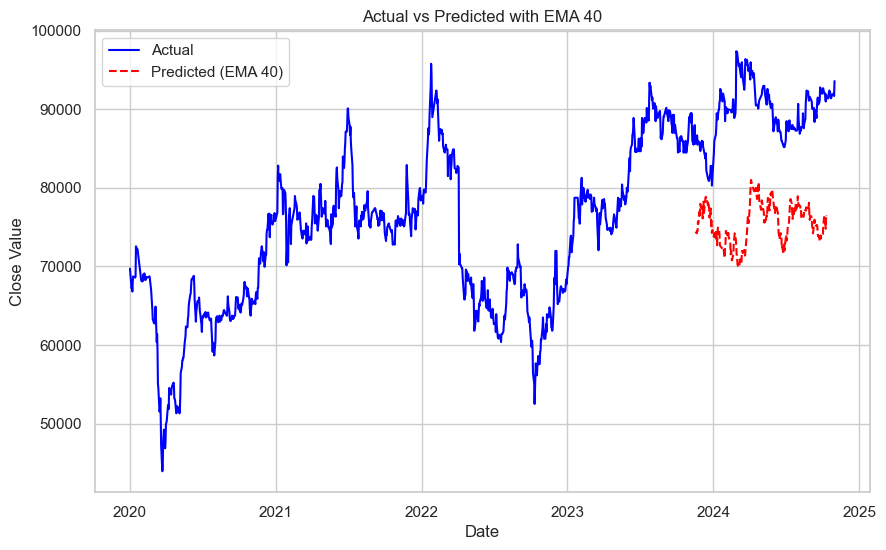

In [139]:
# Chart show result
# Assuming y_pred_rf is the prediction result from the model
# Smooth the predicted data with a 40-period EMA (using either normalized or original data)
y_pred_rf_ema = pd.Series(y_pred_rf).ewm(span=10, adjust=False).mean()
y_pred_rf_sma = pd.Series(y_pred_rf).rolling(window=20).mean()
shifted_index = data_rf_lagged.index[-len(y_pred_rf_sma):] - pd.Timedelta(days=20)
# Plot the chart for actual values and the predicted values smoothed with 40-period EMA
plt.figure(figsize=(10, 6))

# Plot the line for actual values (Close)
plt.plot(data_rf_lagged.index, data_rf_lagged['Close'], label='Actual', color='blue')

# Plot the line for predicted values smoothed (EMA 40)
plt.plot(shifted_index , y_pred_rf_sma, label='Predicted (EMA 40)', color='red', linestyle='--')

# Add a title and axis labels
plt.title('Actual vs Predicted with EMA 40')
plt.xlabel('Date')
plt.ylabel('Close Value')

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
# Insight: 

## 2.3 LSTM

### 2.3.1 Exploratory Data Analyst

#### Preparing data

In [141]:
# VNINDEX data
df_VCB_raw= pd.read_csv(r"C:\Users\ADMIN\OneDrive - Trường ĐH CNTT - University of Information Technology\effort\ki1_nam3\Phân tích thống kê\Đồ án\VCB.csv")
# Rename columns
df_VCB_raw=df_VCB_raw.rename(columns={'Ngày':'Date','Lần cuối':'Close','Mở':'Open','Cao':'High','Thấp':'Low','KL':'Volumne','% Thay đổi':'Change %'})
df_VCB_raw['Date'] = pd.to_datetime(df_VCB_raw['Date'], format='%d/%m/%Y')
# Converting numerical columns from strings to numbers, handling commas
df_VCB_raw['Close'] = pd.to_numeric(df_VCB_raw['Close'].str.replace(',', '', regex=True), errors='coerce')
df_VCB_raw['Open'] = pd.to_numeric(df_VCB_raw['Open'].str.replace(',', '', regex=True), errors='coerce')
df_VCB_raw['High'] = pd.to_numeric(df_VCB_raw['High'].str.replace(',', '', regex=True), errors='coerce')
df_VCB_raw['Low'] = pd.to_numeric(df_VCB_raw['Low'].str.replace(',', '', regex=True), errors='coerce')
# Converting 'Change %' column by removing '%' symbol
df_VCB_raw['Change %'] = pd.to_numeric(
    df_VCB_raw['Change %'].str.replace('%', '', regex=False).str.replace(',', '', regex=True),
    errors='coerce')
# Define a function to convert 'Volumne' values
def convert_to_number(value):
    if isinstance(value, str):
        value = value.replace(',', '')  # Remove commas
        if 'M' in value:
            return float(value.replace('M', '')) * 1_000_000
        elif 'K' in value:
            return float(value.replace('K', '')) * 1_000
        elif 'B' in value:
            return float(value.replace('B', '')) * 1_000_000_000
    return pd.to_numeric(value, errors='coerce')  # Convert remaining values to numeric

# Apply the conversion function to 'Volumne' column
df_VCB_raw['Volumne'] = df_VCB_raw['Volumne'].apply(convert_to_number)

# Display DataFrame info to verify changes
df_VCB_raw.info()
df_VCB_raw = df_VCB_raw.ffill()
df_VCB_raw.set_index('Date', inplace=True)
df_VCB_raw = df_VCB_raw.sort_index(ascending=True)
df_VCB_raw 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207 entries, 0 to 1206
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1207 non-null   datetime64[ns]
 1   Close     1207 non-null   int64         
 2   Open      1207 non-null   int64         
 3   High      1207 non-null   int64         
 4   Low       1207 non-null   int64         
 5   Volumne   1206 non-null   float64       
 6   Change %  1207 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 66.1 KB


,Close,Open,High,Low,Volumne,Change %
Date,,,,,,
2020-01-02,69728,69267,70189,68883,492910.0,0.67
2020-01-03,69037,70265,70496,69037,684100.0,-0.99
2020-01-06,67194,68499,68730,67194,1120000.0,-2.67
2020-01-07,67424,66810,67501,65581,1290000.0,0.34
2020-01-08,66810,66733,67501,66195,921630.0,-0.91
...,...,...,...,...,...,...
2024-10-25,91800,92100,92300,91700,1050000.0,0.11
2024-10-28,92000,91500,92300,91500,1130000.0,0.22
2024-10-29,92000,92100,92600,92000,1400000.0,0.00


#### Drawing line chart

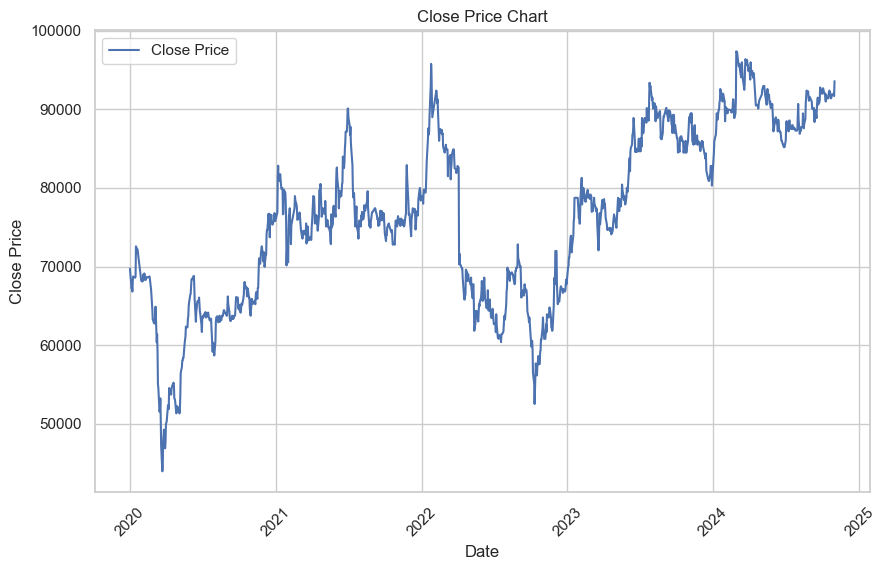

In [143]:
# Line chart for Close price

plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.plot(df_VCB_raw['Close'], label='Close Price', color='b')  # Plot the Close prices
plt.title('Close Price Chart')  # Set the title of the chart
plt.xlabel('Date')  # X-axis label
plt.ylabel('Close Price')  # Y-axis label
plt.legend()  # Show legend
plt.grid(True)  # Show gridlines
plt.xticks(rotation=45)  # Rotate X-axis labels if necessary
plt.show()


#### Data preprocessing

In [145]:
# Preprocessing Close Price
data = df_VCB_raw['Close'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

### 2.3.2 Build model

#### Split data

In [147]:
# Time steps
time_step = 60  # You can change this value based on your needs

# Split the data into sequences
generator = TimeseriesGenerator(scaled_data, scaled_data, length=time_step, batch_size=32)


In [149]:
# Preparing training
# Assuming df_VCB_raw is your DataFrame and contains the 'Close' column
df = df_VCB_raw['Close'].values

# Step 1: Split the data into two subsequences
split_index = int(len(df) * 0.8)  # 80% for the first sequence
data_sequence_1 = df[:split_index]
data_sequence_2 = df[split_index:]

# Step 2: Normalize each sequence using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Normalize both sequences
data_sequence_1_scaled = scaler.fit_transform(data_sequence_1.reshape(-1, 1))
data_sequence_2_scaled = scaler.fit_transform(data_sequence_2.reshape(-1, 1))

# Step 3: Create datasets for each subsequence
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])  # Input features
        y.append(data[i + time_step, 0])      # Target value
    return np.array(X), np.array(y)

# Create datasets for both sequences
time_step = 60  # Number of previous time steps to predict the next value
X1, y1 = create_dataset(data_sequence_1_scaled, time_step)
X2, y2 = create_dataset(data_sequence_2_scaled, time_step)

# Reshape the data to fit LSTM input requirements (samples, time_steps, features)
X1 = X1.reshape(X1.shape[0], X1.shape[1], 1)
X2 = X2.reshape(X2.shape[0], X2.shape[1], 1)

# Step 4: Split the datasets into training and testing sets
train_size_1 = int(len(X1) * 0.8)  # 80% for training, 20% for testing
train_size_2 = int(len(X2) * 0.8)

X1_train, X1_test = X1[:train_size_1], X1[train_size_1:]
y1_train, y1_test = y1[:train_size_1], y1[train_size_1:]

X2_train, X2_test = X2[:train_size_2], X2[train_size_2:]
y2_train, y2_test = y2[:train_size_2], y2[train_size_2:]

# Step 5: Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X1_train.shape[1], 1)))
model.add(Dense(units=1))  # Output layer

model.compile(optimizer='adam', loss='mean_squared_error')

# Step 6: Train the model on the first subsequence
model.fit(X1_train, y1_train, epochs=20, batch_size=32)

# Step 7: Evaluate the model on the first subsequence's test set
y1_pred = model.predict(X1_test)

# Step 8: Inverse transform the predictions to the original scale for the first sequence
y1_pred = scaler.inverse_transform(y1_pred)
y1_test = scaler.inverse_transform(y1_test.reshape(-1, 1))

# Step 9: Train the model on the second subsequence
model.fit(X2_train, y2_train, epochs=20, batch_size=32)

# Step 10: Evaluate the model on the second subsequence's test set
y2_pred = model.predict(X2_test)

# Step 11: Inverse transform the predictions to the original scale for the second sequence
y2_pred = scaler.inverse_transform(y2_pred)
y2_test = scaler.inverse_transform(y2_test.reshape(-1, 1))



D:\Anacoda\Anacoda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.1462
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0058
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0039
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0033
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0030
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0029
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0027
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0024
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0026
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0027
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0025
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0022
Epoch 13/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0024
Epoch 14/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0024
Epoch 15/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0023
Epoc

#### Split into training and testing set

In [151]:
# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)  # 80% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Create datasets for training and testing
X_train, y_train = [], []
X_test, y_test = [], []

for i in range(time_step, len(train_data)):
    X_train.append(train_data[i-time_step:i, 0])  # 60 previous time steps as input data
    y_train.append(train_data[i, 0])             # Predict the next value
    
for i in range(time_step, len(test_data)):
    X_test.append(test_data[i-time_step:i, 0])   # 60 previous time steps as input data
    y_test.append(test_data[i, 0])               # Predict the next value

# Convert data into numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape X_train and X_test to be compatible with LSTM: (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


#### Modelling

In [153]:
# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Reverse the scaling to get values back to their original scale
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Get the last 20% of the test set (by default from the test data that has already been split)
test_size = int(len(y_test_inv) * 0.2)  # 20% of the test set
y_test_inv_20 = y_test_inv[-test_size:]  # Get the last 20% of the test data
y_pred_inv_20 = y_pred_inv[-test_size:]  # Get the last 20% of the predictions

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0016
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0015
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0014
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0014
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0014
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0014
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0012
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0013
Epoch 9/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0012
Epoch 10/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0011
Epoch 11/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0014
Epoch 12/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0012
Epoch 13/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0011
Epoch 14/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0012
Epoch 15/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0014
Epoc

### 2.3.3 Check prediction result

#### Check result

In [196]:
# Calculate MAE, MSE, RMSE, and R^2
mae = mean_absolute_error(y_test_inv, y_pred_inv)

mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R^2): {r2}')


Mean Absolute Error (MAE): 273.25399372717106
Mean Squared Error (MSE): 163934.58848652596
Root Mean Squared Error (RMSE): 404.8883654620443
R-squared (R^2): 0.7955733896377937


### 2.3.4 Visualize prediction results

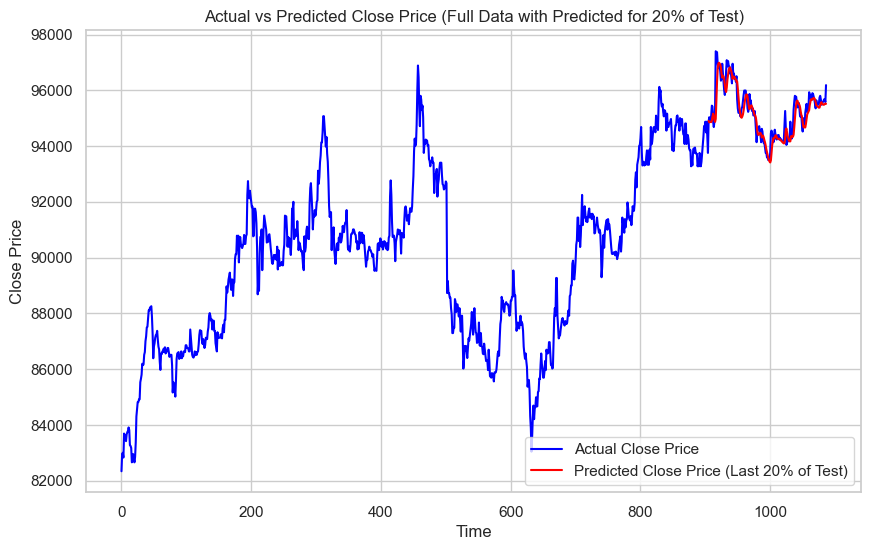

In [200]:
# Plot the entire actual values (y_test_inv + y_train_inv)
# If you have both train and test values, you need to concatenate them before plotting
y_full_inv = np.concatenate((scaler.inverse_transform(y_train.reshape(-1, 1)), y_test_inv), axis=0)

# Get the last 20% of the test set for predictions
test_size = int(len(y_test_inv) * 1)  # 20% of the test set
y_pred_inv_20 = y_pred_inv[-test_size:]  # Get the last 20% of predictions

# Plot the chart
plt.figure(figsize=(10, 6))

# Plot the entire actual values
plt.plot(y_full_inv, color='blue', label='Actual Close Price')  # Actual values

# Plot the predicted values only for the last 20% of the test set
plt.plot(np.arange(len(y_full_inv)-test_size, len(y_full_inv)), y_pred_inv_20, color='red', label='Predicted Close Price (Last 20% of Test)')

plt.title('Actual vs Predicted Close Price (Full Data with Predicted for 20% of Test)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [157]:
# Calculate MAE, MSE, RMSE, and R^2
mae = mean_absolute_error(y_test_inv, y_pred_inv)

mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R^2): {r2}')


Mean Absolute Error (MAE): 273.25399372717106
Mean Squared Error (MSE): 163934.58848652596
Root Mean Squared Error (RMSE): 404.8883654620443
R-squared (R^2): 0.7955733896377937


### 2.3.5 Apply model and predict data for 10 days

#### Prediction

In [204]:
# Use the last 60 days of the test data to predict the next 10 days
last_60_days = X_test[-1]  # Get the last 60 days from X_test

# Predict values for the next 10 days
predicted_prices = []

for _ in range(10):  # Predict the next 10 days
    pred = model.predict(last_60_days.reshape(1, time_step, 1))  # Predict for the next day
    predicted_prices.append(pred[0, 0])  # Append the prediction to the list

    # Update the input data for the next prediction
    last_60_days = np.append(last_60_days[1:], pred, axis=0)  # Append the prediction to the end of the sequence

# Reverse the scaling to get actual values
predicted_prices_inv = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

# Print the predicted prices for the next 10 days
print("Predicted Prices for the next 10 days:")
print(predicted_prices_inv)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted Prices for the next 10 days:
[[95514.98 ]
 [95483.04 ]
 [95445.516]
 [95403.98 ]
 [95359.805]
 [95314.11 ]
 [95267.63 ]
 [95220.86 ]
 [95174.12 ]
 [95127.586]]
